In [41]:
from google.colab import files
from IPython.display import HTML
from numpy.lib import scimath as sm
import numpy as np
import math
from math import sin, cos, radians, pi
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
from scipy.optimize import fsolve
from scipy.integrate import odeint
from sklearn.preprocessing import normalize
import time

Create the environment the leech will move around in

In [42]:
### Leech navigational environment

class Environment():
    def __init__(self,r,x,y,targetLoc):
        self.r = r #Define radius of environment
        self.x = x #Define x,y coordinates for center
        self.y = y
        self.area = 2*pi*(r**2)
        targetLoc = targetLoc*(pi/180)
        ### Define target location
        rG = 7
        self.rG = rG #target radius
        self.aG = targetLoc #target position in environment
        self.xG = (r-self.rG)*cos(targetLoc)+r
        self.yG = (r-self.rG)*sin(targetLoc)+r
    
    def drawEnv(self):
        #boundary = plt.Circle((e.x,e.y),e.r,color='black',fill=False)
        target = plt.Circle((self.xG,self.yG),self.rG,color='black',fill=False)
        fig, ax = plt.subplots()
        #ax.add_artist(boundary)
        ax.add_artist(target)
        ax.set_xlim((0, self.x*2))
        ax.set_ylim((0, self.y*2))
        fig.savefig('Leech Behavioral Arena')
        return fig, ax


Create the leech agent object

In [49]:
class AgentNF():
    def __init__(self,age,x_int,y_int,o_int,WilsonNF):
        # Specify initial positions and orientation
        self.nf = WilsonNF
        self.o = o_int
        self.age = age
        if age == "Adult":
            # Initialize agent size based on age type
            self.height = 2/2
            self.width = 20/2
            self.r = 1
            crawlingVelocity = (self.width/6.4) * (self.nf.tau/1000)
            swimmingVelocity = (self.width/.66) * (self.nf.tau/1000)
        else:
            # Need to add adolescents and juveniles
            self.width = 1
            self.height = 1
            self.r = 1
        #Agent's initial position
        self.x = x_int
        self.y = y_int
        # deltaAngle refers to the agent's change in orientation
        self.deltaAngle = o_int*(pi/180)
        # actual angle is the agents true orientation
        self.actualAngle = o_int*(pi/180)
        
        # This block of code find the elliptical shape of the
        # agent based on the set parameters from the agents age type.
        self.x_coords = np.linspace(-self.width,self.width,int((self.nf.n/2)+1))
        self.yP_coords = np.sqrt((self.height**2)*((self.r**2)-((self.x_coords**2)/(self.width**2))))
        self.yN_coords = -np.sqrt((self.height**2)*((self.r**2)-((self.x_coords**2)/(self.width**2))))
        self.coordsP = np.array([[self.x_coords], # Position values in the ellipse
                                 [self.yP_coords]])
        self.coordsN = np.array([[self.x_coords], # Negative values in the ellispse
                                 [self.yN_coords]])
        
        # Add initial position to agent's elliptical coordinates
        self.coordsP[0] = self.coordsP[0]+self.x
        self.coordsP[1] = self.coordsP[1]+self.y
        self.coordsN[0] = self.coordsN[0]+self.x
        self.coordsN[1] = self.coordsN[1]+self.y
        self.coordsP = self.coordsP.reshape((2,len(self.x_coords)))
        self.coordsN = self.coordsN.reshape((2,len(self.x_coords)))
        
        # Rotate agent based on initial orientation
        self.rotateAgent(self.actualAngle)

        # Specify radius and velocity
        self.v = crawlingVelocity #Agent has constant velocity for now
        # oV is the agent's orientation vector which is used in the update position function
        self.oV = [self.v*cos(self.actualAngle), self.v*sin(self.actualAngle), 0]
        
    ### Helper functions

    # Find distance between two points
    def dist(self,x1,y1,x2,y2):
        return  math.sqrt(((x1-x2)**2) + ((y1-y2)**2))
    
     #Find an orientation vector based on scalar (v) and angle (o)
    def calcAgeVector(self,v,o):   
        if not o:
            o = 0
        theta = o
        x_dir = v*cos(theta)
        y_dir = v*sin(theta)
        z_dir = 0
        return [x_dir, y_dir, z_dir]    
    
    def polVect_to_compVect(self,v,o):
        # Helper function to convert scalar and angle to a vector
        # Same as calcAgeVector but more universal
        compVect = np.zeros(3)
        compVect[0] = v*cos(o)
        compVect[1] = v*sin(o)
        compVect[2] = 0  
        return compVect

    def vectorProjection(self,a,b):
        num = np.dot(a,b)
        dem = b[0]**2 + b[1]**2
        return np.multiply((num/dem),b)
    
    def findWaterAngle(self,a,b):
        # Find an angle between two vector
        # a = water vector
        # b = sensor detection vector
        num = np.dot(a,b)
        normA = np.linalg.norm(a)
        normB = np.linalg.norm(b)
        dem = normA*normB
        
        if (1-(num/dem)) < .0000001:
            n_m = 1
        elif (1+(num/dem)) < .000001:
            n_m = -1
        else:
            n_m = num/dem
        
        theta = math.acos(n_m)
        q = np.cross(a,b)
        angle = theta*(np.sign(q[2]))
        return angle*(180/math.pi)
    
    def findNFAngle(self,WilsonNF,n):
        # Simple getter function to retrieve percieved angle from the neural field based on input vectors
        percievedAngle = WilsonNF.perceived[n] * (pi/180)
        return percievedAngle
        
    def updateAngle(self,WilsonNF,n):
        # Update delta angle based on percieved angle from the neural field
        deltaAngle = self.findNFAngle(WilsonNF,n)
        self.deltaAngle = deltaAngle
        return deltaAngle

    def updateOrientationVector(self,n):
        # Update orientation vector based on percieved angle from the neural field
        self.deltaAngle = n*(pi/180)
        angularVel = self.calcAgeVector(self.v,self.actualAngle)
        angVel = self.calcAngVel(self.deltaAngle)
        self.actualAngle = self.actualAngle + angVel
        self.oV = self.polVect_to_compVect(self.v,self.actualAngle)
        self.rotateAgent(angVel) # Once orientations are updated, rotate
        return self.oV

    # Proportional control method
    def calcAngVel(self,ang):  
        k_p = .4
        angVel = (k_p * ang)
        return angVel * (self.nf.tau/1000)   

    # 2D rotation matrix function used to rotate ellipse    
    def rotate(self,coords,theta):
        # coords[0] and coords[1] are arrays of length 2 with the x, y coordinate of
        # your segments extreme points with the form [x, y]
        if not theta:
            theta = 0
        mid = np.array([[(coords[0,-1]+coords[0,0])/2],
                        [(coords[1,-1]+coords[1,0])/2]])
        # Make the midpoint the origin
        coords_mid = coords - mid
        # Use the rotation matrix from the paper you mentioned
        trans = np.array([[cos(theta), -sin(theta)],
                          [sin(theta), cos(theta)]])
        rotated = np.dot(trans,coords_mid)
        # Then add the midpoint coordinates to return to previous origin
        rotated = rotated + mid
        return rotated
    
    def rotateAgent(self,angVel):
        self.coordsP = self.rotate(self.coordsP,angVel)
        self.coordsN = self.rotate(self.coordsN,angVel)

    # Update agents position with orientation vector    
    def updatePosition(self,Environment):
        self.checkInSquareBoundary(Environment)    
        self.x = self.x + self.oV[0]
        self.y = self.y + self.oV[1]
        self.coordsP[0] = self.coordsP[0]+self.oV[0]
        self.coordsP[1] = self.coordsP[1]+self.oV[1]
        self.coordsN[0] = self.coordsN[0]+self.oV[0]
        self.coordsN[1] = self.coordsN[1]+self.oV[1]
        return [self.x, self.y, 0]
        
    def checkInSquareBoundary(self,Environment):
        e = Environment
        if abs(self.x - (e.x*2)) < self.v or abs(self.x - 0) < self.v:
            # Impact detector on horizontal walls
            self.oV[0] = -self.oV[0]
            self.deltaAngle = pi
            self.actualAngle = self.actualAngle+self.deltaAngle
            self.rotateAgent(180)
        elif abs(self.y - (e.y*2)) < 1 or abs(self.y - 0) < 1:
            # Impact detector on vertical walls
            self.oV[1] = -self.oV[1] 
            self.deltaAngle = pi
            self.actualAngle = self.actualAngle+self.deltaAngle
            self.rotateAgent(180)
        
    def checkInTarget(self,Environment):
        e = Environment
        d = self.dist(self.x,self.y,e.xG,e.yG)
        if d+self.r <= e.rG:
            self.count += 1
            return True
        else:
            self.count = 0
            return False

    def checkFind(self,Environment):
        inTarget = self.checkInTarget(Environment)
        if inTarget == False:
            return False
        else:
            # If agent is in the target location for n tim steps, stop and count it as a find
            # else continue moving until time runs out.
            n = 2
            if self.count == n:
                return True
            else:
                return False
            
    def plotAgent(self,color):
        plt.plot(self.coordsP[0],self.coordsP[1],self.coordsN[0],self.coordsN[1],color=color) # Agent body
        plt.scatter(self.coordsP[0][-1],self.coordsP[1][-1],c='red',s=20) # Agent orientation marker


Create the winner take all neural field that Wilson developed in Spikes, Decisions, and Actions

In [44]:
# This neural field is very similar to Wilson's winner take all model
# Must have plotly downloaded to see 3D surface plots

class WilsonNF():
    def __init__(self,size,ang,tau):
        self.n = 24 # number of neural populations
        t = 100 # number of time steps
        self.t = 20
        self.n_spaces = int((180+180)/self.n)
        self.x = np.arange(-180,180,self.n_spaces)*(pi/180)
        self.threshold = 0.2
        
        self.tau = tau # time constant
        #Input parameter arrays
        self.size = np.array(size) # Size of vectors
        self.ang = np.array(ang)*(pi/180)   # Angle of vectors
        self.previousSize = self.size
        self.previousAng = self.ang
        
        self.weight = -1*np.array([1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1]) # Weighting array
        self.tspan = np.linspace(1,t,t) # Time steps
         
        # Allocate space for neural field
        self.decay = 0
        self.maxTime = 300
        self.numFrames = np.int(np.round(self.maxTime/(self.tau/1000)))
        self.time = 0
        self.inputs = np.zeros((1,self.n))
        self.neurons = np.zeros((1,self.n))
        self.maxResp = np.zeros(self.numFrames)
        self.totalResp = np.zeros((self.n,self.numFrames))
        self.offset = 0
        self.perceived = []
        self.allInputs = np.zeros((self.n,self.numFrames))

    def updateNF(self,sizeIn,angIn,noiseBool):
      self.updateInputs(sizeIn,angIn,noiseBool)
      self.diffEq()
      perceived = []
      if np.max(self.neurons) > self.threshold:
        perceived = self.calcCosWeightedVect()
        # self.neurons = np.zeros((1,self.n))
        self.perceived = perceived
      self.time += 1
      self.inputs = np.zeros((1,self.n))
      
      return perceived
    
    def addNoise(self,noiseAngStrength,noiseSizeStrength,length):
      n = len(length)
      noiseAng = np.random.randn(n)*noiseAngStrength
      noiseSize = np.random.randn(n)*noiseSizeStrength
      return noiseAng, noiseAng
    
    def updateInputs(self,sizeIn,angIn,noiseBool):
        # Input parameter arrays
        if noiseBool:
          noiseAngle_strength = 45**(pi/180) # set to zero for no noise
          noiseSize_strength = 0

        else:
          noiseAngle_strength = 0
          noiseSize_strength = 0
        if len(sizeIn) == 0:
            # Test out constant negative input
            # noise = self.addNoise(noise_strength,self.previousAng)
            self.size = self.size - self.decay
            self.ang = self.previousAng
            # noise = self.addNoise(noise_strength,self.previousAng)
            # self.size = self.previousSize
            # self.ang = np.add(self.previousAng,noise)
        else:
            self.inputs = np.zeros((1,self.n))
            noiseAng,noiseSize = self.addNoise(noiseAngle_strength,noiseSize_strength,angIn)
            self.previousAng = self.ang
            self.previousSize = self.size
            # self.size = np.add(np.array(sizeIn),noiseSize) # Array of vector sizes
            self.ang = np.add(np.array(angIn),noiseAng)   # Array of vector angles
            self.size = np.array(sizeIn)
            self.ang = np.array(angIn)

    def updateAngOffset(self,offset):
        self.offset = offset*(pi/180)
          
    def resetVals(self):
        self.inputs = np.zeros((1,self.n))
        self.allInputs = np.zeros((self.n,self.numFrames))
        self.neurons = np.zeros((1,self.n))
        self.maxResp = np.zeros(self.numFrames)
        self.totalResp = np.zeros((self.n,self.numFrames))
        self.time = 0
    def resetTime(self):
      self.time = 0
   
    def setDecay(self,n):
      self.decay = n
        
    def calcInputs(self):
        ang = self.ang*(pi/180)
        rawInput = np.zeros(self.n)
        for i in range(0,len(self.size)-1):
            # print('size',self.size[i],'ang',ang[i])
            # print(self.size[i]*np.cos(self.x-ang[i]))
            self.inputs = self.inputs + np.multiply(self.size[i]*np.cos(self.x-(ang[i])),
                                                    (np.cos(self.x-(ang[i]))>=0))
        
        self.allInputs[:,self.time] = self.inputs
        return self.inputs
    
    def calcWeightScale(self,inputs):
        n = np.max(inputs)
        if n == 0:
          return 0
        return (1/n**2)

    def diffEq(self):
        #solve ivp
        inputs = self.calcInputs()
        weightScale = self.calcWeightScale(inputs)
        PSP = inputs + self.circleConv(self.weight*weightScale,self.neurons)
        PSP = (PSP)*(PSP>0)
        self.neurons = self.neurons + (2*(self.tau/1000))*(-self.neurons+PSP)
        self.maxResp[self.time] = np.max(self.neurons)
        self.totalResp[:,self.time] = np.reshape(self.neurons[:],self.neurons.shape[1])
        return self.neurons
            
    def circleConv(self,filt,inputs):
        n = inputs.shape[1]
        inp = np.reshape(np.concatenate((inputs,inputs,inputs)),(n*3))
        filt = np.reshape(filt,len(filt))
        x = np.convolve(filt,inp)
        x = x.reshape((1,-1))
        extra = np.int(np.floor(len(filt)/2))
        x = x[0][extra:x.shape[1]-extra]
        Result = x[n:2*n]
        Result = Result.reshape((1,-1))
        return Result
    
    def calcResultantVect(self):
        self.diffEq()
        polVectors = np.zeros((24,2))
        polVectors[:,0] = totalResp[:,-1]
        polVectors[:,1] = (self.x)*(180/math.pi)
        compVectors = self.polVect_to_compVect(polVectors)
        resultantVector = np.zeros(2)
        resultantVector[0] = np.sum(compVectors[:,0])
        resultantVector[1] = np.sum(compVectors[:,1])
        return resultantVector, polVectors, compVectors
    
    def calcFinalAngle(self):
        [a,b,c] = self.calcResultantVect()
        finalAng = math.atan(a[1]/a[0])*(180/math.pi)
        return finalAng
    
    def parabolaInt(self,Rminus1,Rmax,Rplus1,MaxX,Del):
        Num = Del*(Rplus1 - Rminus1)
        Denom = 2*(Rplus1 + Rminus1 - 2*Rmax)
        PB = -Num/Denom - MaxX
        return PB
    
    def calcCosWeightedVect(self):
        Neurons = self.neurons
        perceivedDirs = [] 
        count = 0
        for neuron in Neurons[0]:
          if neuron > self.threshold:
            count+=1
            jj = np.where(Neurons == neuron)[1]  
            plotorient = -np.arange(-180,180,15)
            if jj == 0:
              perceivedDir = self.parabolaInt(Neurons[0,jj], Neurons[0,jj], Neurons[0,jj+1], plotorient[jj], 15)
            elif jj == self.n-1:
              perceivedDir = self.parabolaInt(Neurons[0,jj-1], Neurons[0,jj], Neurons[0,jj], plotorient[jj], 15)
            else:
              perceivedDir = self.parabolaInt(Neurons[0,jj-1], Neurons[0,jj], Neurons[0,jj+1], plotorient[jj], 15)
            perceivedDirs.append(perceivedDir)
        if count == 0:
          return []
        return perceivedDirs
     
    def polVect_to_compVect(self,v):
        compVect = np.zeros((24,2))
        for i in range(len(v)):
            compVect[i,0] = v[i,0]*cos(v[i,1]*(math.pi/180))
            compVect[i,1] = v[i,0]*sin(v[i,1]*(math.pi/180))
        return compVect
    
    def plotMaxResp(self):
        plt.xlabel("Timesteps",FontSize = 30)
        plt.ylabel("Maximum neural response",FontSize = 30)
        plt.title("Maximum neural reponse vs. Time",FontSize = 30)
        plt.xticks(fontsize= 20)
        plt.yticks(fontsize= 20)
        plt.plot(np.arange(0,self.time),self.maxResp[0:self.time])
    
    def plotInputs(self):
        fig = go.Figure(go.Surface(
            contours = {
                "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
                "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
            },
            x = np.arange(0,self.time),
            y = (self.x)*(180/math.pi), # transpose
            z = self.allInputs
            ))
        fig.update_layout(scene = dict(
            xaxis_title="Timesteps",
            yaxis_title="Sensor Location (degrees)",
            zaxis_title="Raw Sensor Input"),
            width=500,
            margin=dict(r=20, b=10, l=10, t=10))
        fig.update_layout(
            scene = {      
                "xaxis": {"nticks": 20},
                "zaxis": {"nticks": 4},
                'camera_eye': {"x": -3.5, "y": -1, "z": 1.5},
                "aspectratio": {"x": 2, "y": 1, "z": 0.2}
            })  
        fig.show()

    def plotSurface(self):
        totalResp = self.totalResp
        fig = go.Figure(go.Surface(
            contours = {
                "x": {"show": True, "start": 1.5, "end": 2, "size": 0.04, "color":"white"},
                "z": {"show": True, "start": 0.5, "end": 0.8, "size": 0.05}
            },
            x = np.arange(0,self.time),
            y = (self.x)*(180/math.pi), # transpose
            z = totalResp[:,0:self.time]
            ))
        fig.update_layout(scene = dict(
            xaxis_title="Timesteps",
            yaxis_title="Position (degrees)",
            zaxis_title="Neural activation"),
            width=500,
            margin=dict(r=20, b=10, l=10, t=10))
        fig.update_layout(
            scene = {      
                "xaxis": {"nticks": 20},
                "zaxis": {"nticks": 4},
                'camera_eye': {"x": -3.5, "y": -1, "z": 1.5},
                "aspectratio": {"x": 2, "y": 1, "z": 0.2}
            })  
        fig.show()

Create the water wave object
- this is mainly used for animation purposes
- the important parts of this code are the wavenumber calculation

In [45]:
class Wave():
    def __init__(self,environment,frequency,depth):
        # Define x,y space the wave propagates over, in this case it is a square
        size = environment.x/100
        pixels = 84
        x = np.linspace(-size,size,pixels)
        y = np.linspace(-size,size,pixels)
        self.e = environment
        x_center = ((self.e.xG/100)-(pixels/200))
        y_center = ((self.e.yG/100)-(pixels/200))
        self.x,self.y = np.meshgrid(x-x_center,y-y_center)

        self.g = 9.8 # gravitational constant
        self.a = .04 # amplitude of wave in meters
        self.frequency = frequency # frequency in hertz (1/seconds)
        self.T = 1/frequency # time period of wave
        self.h = depth # depth of water in meters
        
        func_solve = lambda x,f,h : (self.g/2*pi)*((1/f)**2)*np.tanh(2*pi*h/x) - x
        lambda_func = lambda x : func_solve(x,self.frequency,self.h)
        self.wavelength = fsolve(lambda_func,1)
  
        self.k = (2*pi)/self.wavelength
        # self.w = (2*pi)/self.T
        self.w = np.sqrt(self.g*self.k*math.tanh(self.k*self.h)) # Angular frequency

        self.z = np.zeros((1,len(x)*len(y))) # Water elevation matrix
        [self.rMin, self.rMax] = [4,5]
        
    def waterSurfaceElevation(self,x,y,t):
        n = self.a*np.sin(self.theta(x,y,t))
        return n
    
    def theta(self,x,y,t):
        R = np.sqrt(x**2+y**2)
        return (self.k*R)-self.w*t

    def update(self,t):
        self.z = self.waterSurfaceElevation(self.x,self.y,t)
        return self.z

    def normalizeIntensity(self,z):
        rMin = self.rMin
        rMax = self.rMax
        tMin = -100
        tMax = 200
        intensity = ((z - rMin)/(rMax-rMin))*(tMax-tMin)+tMin
        return intensity

    def getIntensity(self,x_coords,y_coords):
        if x_coords > len(self.x)-1 or y_coords > len(self.y)-1:
          intensity = 0
        else:
          intensity = self.z[x_coords,y_coords]
        # intensity = self.normalizeIntensity(intensity)
        return intensity

    def plotWave(self,ax):
        plt.imshow(np.floor(self.z*100), cmap='jet', aspect='auto', vmin=0,vmax=30)
        ax.invert_yaxis()
        ax.set_xlim((0,(self.e.x*2)-1))
        ax.set_ylim((0,self.e.x*2))



Simulation object that combines all the objects together and tests out agent trajectories with different wave frequencies and depths

In [46]:
class Simulation():
    def __init__(self,components,parameters):
      
      self.env = components[0]
      self.nf = components[1]
      self.agent = components[2]
      self.agent_init = [self.agent.age,self.agent.x,self.agent.y,self.agent.o,self.agent.nf]

      self.frequency = 1
      self.h = 1
      self.numFrames = parameters[0] # frames
      self.tau = parameters[1]
      
      self.pointWave = Wave(self.env,self.frequency,self.h)
           
      self.sizes = np.zeros(((self.agent.coordsP.shape[1]-1)*2,self.numFrames+2))
      self.angles = np.zeros(((self.agent.coordsP.shape[1]-1)*2,self.numFrames+2))
      self.positions = np.zeros((self.numFrames+2,2))
      self.positions[0,:] = [self.agent.x,self.agent.y]
      # self.orientation = np.zeros((self.numFrames+2,4))
      # self.orientation[0,:] = [self.agent.coords[0][-1],self.agent.coords[1][-1],self.agent.coordsP[0][-1], self.agent.coordsP[1][-1]+3]
      
      self.t = 0
      self.success = 0
      self.randomTurn = 0

      print(self.numFrames)

    def updateFrequency(self,n):
      self.frequency = n
      self.pointWave = Wave(self.env,self.frequency,self.h)
    def updateDepth(self,n):
      self.h = n
      self.pointWave = Wave(self.env,self.frequency,self.h)
    def resetVals(self):
      self.sizes = np.zeros(((self.agent.coordsP.shape[1]-1)*2,self.numFrames+2))
      self.angles = np.zeros(((self.agent.coordsP.shape[1]-1)*2,self.numFrames+2))
      self.positions = np.zeros((self.numFrames+2,2))
      self.agent = AgentNF(self.agent_init[0],self.agent_init[1],self.agent_init[2],self.agent_init[3],self.agent_init[4])
      self.t = 0
      
    def sensorVector(self,v,theta):
      theta = theta*(pi/180)
      x = v*cos(theta)
      y = v*sin(theta)
      return x,y,0
    def update(self,k,switch):
      a = self.agent
      water = self.pointWave
      e = self.env
      nf = self.nf
      timet = self.t*(tau/1000)
      # Allocate space for input size vector and input angle vector
      cP = 0
      cN = 0
      count = 0
      sizeThreshold = 0
      angleThreshold = 30

      if k < switch:
        # Check the intensity and direction of the water particle touching the leech and use it as the input vectors
        for i in range((a.coordsP.shape[1]-1)*2):
          ### Positive elliptical points
            if i%2 == 0:
                ### Find sensor detector vectors
                sensorAngleP = (((nf.x*(180/pi)+180))+a.actualAngle*(180/pi))[cP]
                sensorPVector = self.sensorVector(100,sensorAngleP)

                ### Water stimuli vector
                wX = e.xG - a.coordsP[0,-cP-1]
                wY = e.yG - a.coordsP[1,-cP-1]
                waterPVector = ([wX,wY,0] / (np.sqrt(wX**2 + wY**2)))*(water.k/250)

                ### Find angle between two vectors
                angleP = a.findWaterAngle(sensorPVector,waterPVector)
                if abs(angleP) < 90:
                  ### Find the projection of the water vector onto the sensor detector vector
                  pProj = a.vectorProjection(waterPVector,sensorPVector)
                  magnitude = np.sqrt(pProj[0]**2 + pProj[1]**2)
                  self.sizes[count,self.t+1] = magnitude
                  self.angles[count,self.t+1] = sensorAngleP-(a.actualAngle*(180/pi))
                  
                else:
                  self.sizes[count,self.t+1] = 0
                  self.angles[count,self.t+1] = sensorAngleP-(a.actualAngle*(180/pi))
                cP+=1
                count+=1
            else:
                if cN == 0 or cN == 12:
                    skip_zero_and_twelve = True
                # Negative elliptical points
                else:
                    ### Find sensor detector vectors
                    sensorAngleN = (((nf.x*(180/pi)+180))+a.actualAngle*(180/pi))[-cN] - 360
                    sensorNVector = self.sensorVector(100,sensorAngleN)

                    ### Water stimuli vector
                    wX = e.xG - a.coordsN[0,-cN-1]
                    wY = e.yG - a.coordsN[1,-cN-1]
                    waterNVector = ([wX,wY,0] / (np.sqrt(wX**2 + wY**2)))*(water.k/250)

                    ### Find angle between two vectors
                    angleN = a.findWaterAngle(sensorNVector,waterNVector)
                    if abs(angleN) < 90:
                      ### Find the projection of the water vector onto the sensor detector vector
                      nProj = a.vectorProjection(waterNVector,sensorNVector)
                      magnitude = np.sqrt(nProj[0]**2 + nProj[1]**2)
                      self.sizes[count,self.t+1] = magnitude
                      self.angles[count,self.t+1] = sensorAngleN-(a.actualAngle*(180/pi))
                      
                    else:
                      self.sizes[count,self.t+1] = 0
                      self.angles[count,self.t+1] = sensorAngleN-(a.actualAngle*(180/pi))
                cN+=1
                count+=1

        ### Behavioral decision
        perceived = nf.updateNF(self.sizes[:,self.t+1],self.angles[:,self.t+1],noiseBool = True)
      
        if len(perceived) == 0:
          # If no percieved directions were returned then the agent performs a random turn and has a 75% chance of moving
          n = random.randint(-20,20)*pi/180
          self.randomTurn += n
          vel = a.updateOrientationVector(self.randomTurn)  
          m = random.randint(0,4)
          if m > 1:
            pos = a.updatePosition(e)
        else:
          # If there were returned perceived directions then on of those directions is randomly chosen
          n = random.randint(0,len(perceived)-1)
          turnAngle = perceived[n]
          turn = abs(turnAngle) > 5
          if turn:
            # If the perceived angle is greater than 5 degrees then it turns, updates its orientation, and moves
            vel = a.updateOrientationVector(turnAngle)   
            pos = a.updatePosition(e)
          else:
            # Other just move
            pos = a.updatePosition(e)

        #nf.plotSurface()
        # vel = a.updateOrientationVector(nf)
        # print('angles',trimmedAngls)
        # print('sizes',trimmedSizes)
      else:
        perceived = nf.updateNF([],[],noiseBool = True)
        if len(perceived) == 0:
          # If no percieved directions were returned then the agent performs a random turn and has a 75% chance of moving
          n = random.randint(-10,10)
          self.randomTurn += n
          vel = a.updateOrientationVector(self.randomTurn)  
          m = random.randint(0,4)
          if m > 1:
            pos = a.updatePosition(e)
        else:
          # If there were returned perceived directions then on of those directions is randomly chosen
          n = random.randint(0,len(perceived)-1)
          turnAngle = perceived[n]
          turn = abs(turnAngle) > 5
          if turn:
            # If the perceived angle is greater than 5 degrees then it turns, updates its orientation, and moves
            vel = a.updateOrientationVector(turnAngle)   
            pos = a.updatePosition(e)
          else:
            # Other just move
            pos = a.updatePosition(e)


      self.positions[1+self.t,:] = a.x,a.y
      # self.orientation[1+selt.t,:] = [a.coords[0][-1],a.coords[1][-1],a.coordsP[0][-1],a.coordsP[1][-1]+3]
      self.t +=1

    def run(self):
      count = 0
      # Switch variable is used to change the agent between actively taking in
      # environmental information not taking in information.
      timeSwitch = 2 # Number of seconds the agent takes in information for
      switch = timeSwitch/(self.tau/1000)
      frame = 0
      for k in range(self.numFrames-1):
        self.update(frame,switch)
        frame += 1
        # agent takes in information for 2 seconds and is idle for 4 seconds
        if frame > switch*3:
          # After the total 6 seconds, the frame counter is set back to zero
          frame = 0
        if (((self.agent.x-self.env.xG)**2)+((self.agent.y-self.env.yG)**2))**(1/2) + 3 <= self.env.rG:
            count += 1 
            if count == 100:
              self.success = 1  
              print("Find")               
              return
        else:
            count = 0
      self.success = 0
      return

    def plotTrajectory(self):
      plt.scatter(self.positions[1:self.t,0],self.positions[1:self.t,1])
      plt.xlim([0,self.env.x*2])
      plt.ylim([0,self.env.x*2])
      plt.plot([self.env.xG-self.env.rG,self.env.xG+self.env.rG],[self.env.yG,self.env.yG],color = 'black')
      plt.plot([self.env.xG,self.env.xG],[self.env.yG-self.env.rG,self.env.yG+self.env.rG],color = 'black')
      plt.Circle((self.env.xG,self.env.yG),self.env.rG,color='black',fill=False)

First main script to test out and visualize agent trajectories, neural field inputs, and neural field surface plot outputs

1200
Find


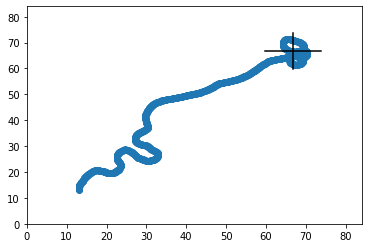

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

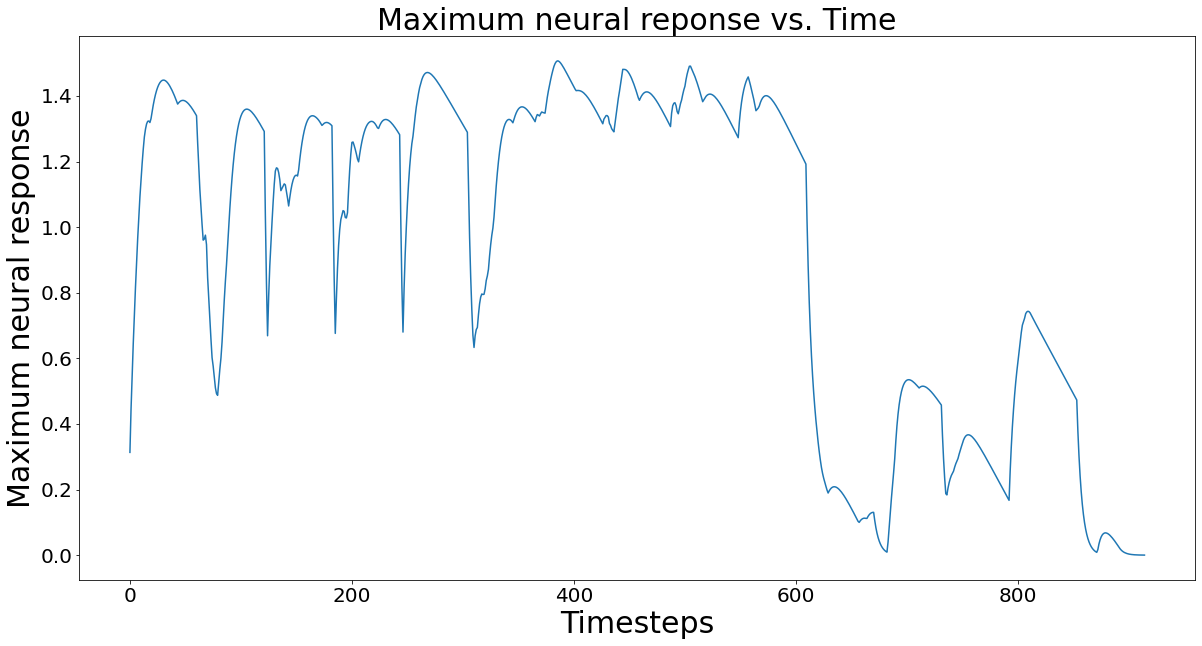

In [47]:
# Define variables for env boundaries, agent starting location, wave frequency
bounds = 42 # set environment to be a 84x84cm square
targetLocation = 45 # sets the target location to be certain degrees from the horizontal on a 42cm radius circle in the environment
orientation_init = 90 # initial orientation for the agent
[x_init, y_init] = [13,13] # starting coordinate for the agent
fps = 10
tau = 1000 / fps # time constant
t = 120
numFrames = np.int(np.round(t/(tau/1000))) # simulation time in seconds

#Create instance of behavioral arena, agent, neural field, and water waves
e = Environment(bounds,bounds,bounds,targetLocation)
nf = WilsonNF([0,0],[orientation_init,orientation_init],tau)
nf.setDecay(0.0008) # Set the neural field's decay value
a = AgentNF("Adult",x_init,y_init,orientation_init,nf)

# Add simulation components (environment, neural field, and agent)
components = [e,nf,a]
# Add simulation parameters (number of frames and time constant)
parameters = [numFrames,tau]

sim = Simulation(components,parameters) # Create instance of a simulation
sim.resetVals() # Reset the values and update frequency and depth values
sim.updateFrequency(12)
sim.updateDepth(.02)
plt.figure(0)
sim.run() # Run the simulation for certain number of frames
sim.plotTrajectory() # Plot agent trajectory
plt.figure(1)
nf.plotInputs() # Plot the neural field input
plt.figure(2)
nf.plotSurface() # Plot neural field output
plt.figure(figsize=(20, 10)) 
nf.plotMaxResp() # Plot the response of the maximally actiovated neuron

Second main script that runs n number of trials for different frequencies of water wave inputs at different water depths
- Outputs find rate vs wave frequency for each water depth
- and average maximum neural response vs water frequency for each water depth

1200
Find
Find
Find
Find
Find
Find
Find
Find
Find
Find
Find
Find
Find
Find
It took 74.88476061820984 seconds to run the simulation


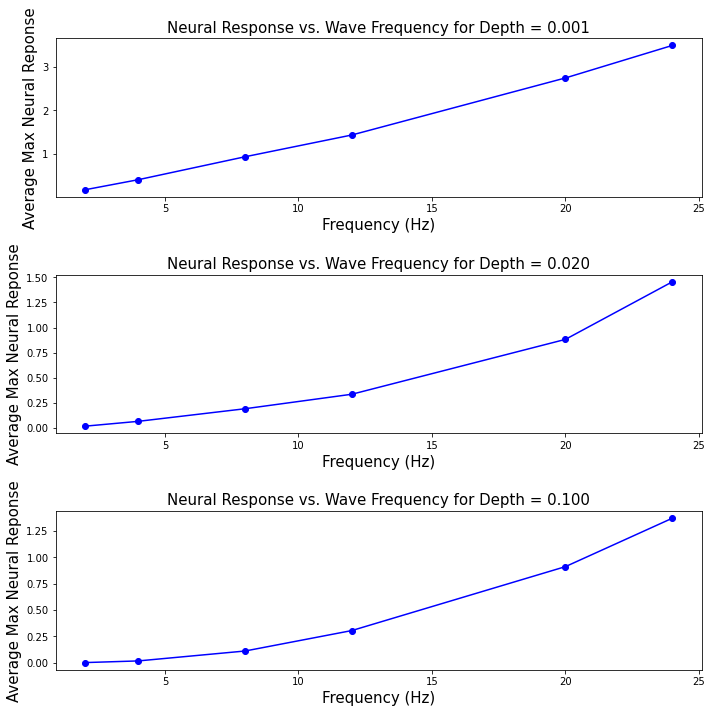

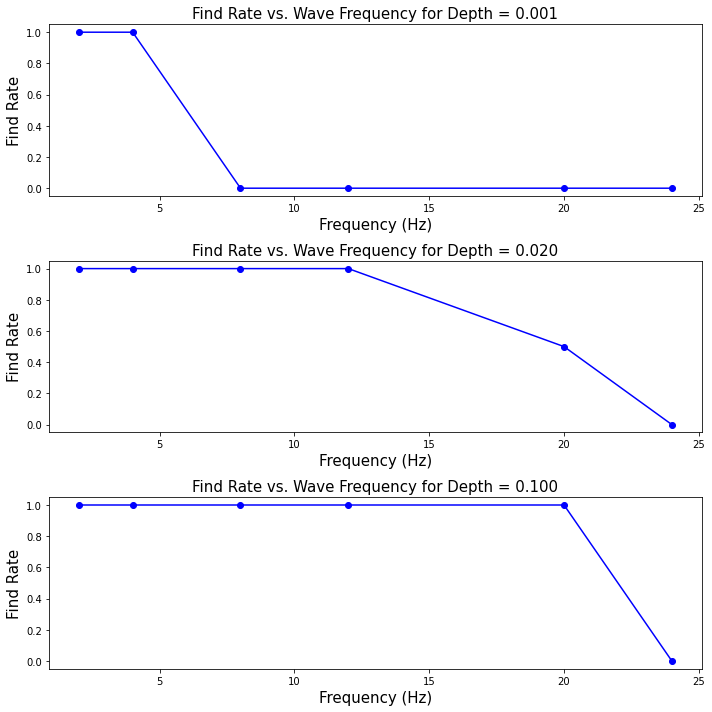

In [52]:
start_sim = time.time()
# Define variables for env boundaries, agent starting location, wave frequency
bounds = 42 # set environment to be a 84x84cm square
targetLocation = 45 # sets the target location to be certain degrees from the horizontal on a 42 radius circle in the environment
orientation_init = 90 # initial orientation for the agent
[x_init, y_init] = [13,13] # starting coordinate for the agent
f = [2,4,8,12,20,24]
depth = [.001,.02,.1]
N = len(f)
fps = 10
tau = 1000 / fps # time constant
t = 120
numFrames = np.int(np.round(t/(tau/1000))) # simulation time in seconds

#Create instance of behavioral arena, agent, neural field, and water waves
simE = Environment(bounds,bounds,bounds,targetLocation)
simNF = WilsonNF([20,20],[orientation_init,orientation_init],tau)
simNF.setDecay(.0008)
simA = AgentNF("Adult",x_init,y_init,orientation_init,nf)

trials = 2
success = np.zeros((N,trials))

components = [simE,simNF,simA]
parameters = [numFrames,tau]


sim = Simulation(components,parameters)

depth_legend = []
figN,axN = plt.subplots(len(depth),1,figsize = (10,10))
figF,axF = plt.subplots(len(depth),figsize = (10,10))
for k in range(len(depth)):
    sim.updateDepth(depth[k])
    legend_tuple = []
    maxAvg = np.zeros(N)
    for i in range(N):
      sim.updateFrequency(f[i])
      count = 0
      for j in range(trials):
        sim.resetVals()
        simNF.resetTime()
        simNF.resetVals()
        parameters[0] = f[i]
        sim.run()
        if sim.success == 1:
          success[i,j] = 1
        # plt.figure(k)
        # simNF.plotMaxResp()
        maxAvg[i] = maxAvg[i] + np.average(simNF.maxResp[0:simNF.time])
        # legend_tuple.append("f = {0:0.0f} Hz".format(f[i]))

    # axN[k].title("Max Neural Reponse, depth = {0:0.2f} m".format(depth[k]))
    # plt.gca().legend(tuple(legend_tuple),loc = 'best')
    # plt.figure(len(depth)+1)
    axN[k].plot(f,maxAvg/N,'-bo')
    # depth_legend.append("h = {0:0.2f} m".format(depth[k]))
    axN[k].set_xlabel("Frequency (Hz)",FontSize = 15)
    axN[k].set_ylabel("Average Max Neural Reponse",FontSize = 15)
    axN[k].set_title("Neural Response vs. Wave Frequency for Depth = {0:0.3f}".format(depth[k]),FontSize = 15)
    results = np.zeros(N)
    for i in range(N):
      count = 0
      for j in range(trials):
        if success[i,j] == 1:
          count+=1
      results[i] = count/trials
    axF[k].plot(f,results,'-bo')
    axF[k].set_ylabel("Find Rate",FontSize = 15)
    axF[k].set_xlabel("Frequency (Hz)",FontSize = 15)
    axF[k].set_title("Find Rate vs. Wave Frequency for Depth = {0:0.3f}".format(depth[k]),FontSize = 15)

figN.tight_layout() 
figF.tight_layout() 
# plt.figure(len(depth)+1)
# plt.gca().legend(tuple(depth_legend),loc = 'best')

# err = np.zeros(N)
# for i in range(N):
#   err[i] = np.std(success[i,:])/(trials**(1/2))


print("It took",time.time()-start_sim,"seconds to run the simulation")